# Audio Classification
This notebook is a sample 

## Read .wav file

### Show original sample rate and librosa sample rate

In [11]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = '../ESC-50/audio/2-80313-A-28.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate)

Original sample rate: 44100
Librosa sample rate: 22050


### Show range of audio

In [12]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -13778 to 9359
Librosa audio file min~max range: -0.41892296 to 0.28566685


### Show wave

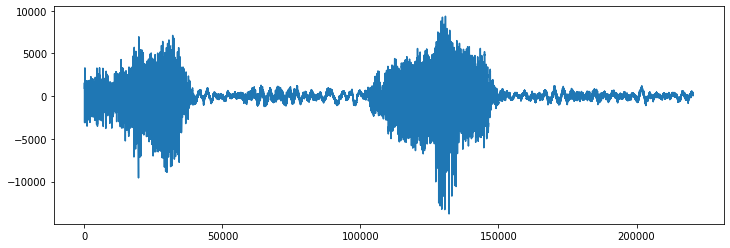

In [13]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

## Get feature of the audio
### Use mfcc

In [15]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 216)


### Display mfcc image

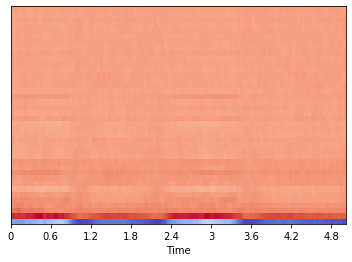

In [16]:
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

## Start building Audio Classification program

In [26]:
import numpy as np
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=120)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [27]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = '../ESC-50/audio/'

metadata = pd.read_csv('../ESC-50/meta/esc50.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),str(row["filename"]))
    
    class_label = row["category"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  2000  files


In [28]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [29]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [45]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(120,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [46]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [47]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               30976     
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_20 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)               

In [48]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 2000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='save_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

print(x_train.shape)

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

========] - 0s 55us/step - loss: 0.5187 - accuracy: 0.8719 - val_loss: 4.6006 - val_accuracy: 0.4600

Epoch 01902: val_loss did not improve from 2.31158
Epoch 1903/2000
1600/1600 [==============================] - 0s 58us/step - loss: 0.4165 - accuracy: 0.8913 - val_loss: 4.6797 - val_accuracy: 0.4725

Epoch 01903: val_loss did not improve from 2.31158
Epoch 1904/2000
1600/1600 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.8825 - val_loss: 4.6616 - val_accuracy: 0.4600

Epoch 01904: val_loss did not improve from 2.31158
Epoch 1905/2000
1600/1600 [==============================] - 0s 60us/step - loss: 0.4642 - accuracy: 0.8913 - val_loss: 4.5695 - val_accuracy: 0.4650

Epoch 01905: val_loss did not improve from 2.31158
Epoch 1906/2000
1600/1600 [==============================] - 0s 58us/step - loss: 0.4469 - accuracy: 0.8906 - val_loss: 4.5533 - val_accuracy: 0.4675

Epoch 01906: val_loss did not improve from 2.31158
Epoch 1907/2000
1600/1600 [============

In [49]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9793750047683716
Testing Accuracy:  0.4650000035762787
